In [89]:
# !pip install tensorflow numpy pandas matplotlib seaborn xgboost scikit-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import gym
import networkx as nx
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Attention
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping




In [90]:
df = pd.read_csv('updated_solar.csv')
print(df.columns)

Index(['hour', 'dayofweek', 'month', 'is_weekend', 'hour_sin', 'hour_cos',
       'dayofyear_sin', 'dayofyear_cos', 'DE_solar_generation_actual',
       'DE_ALLSKY_SFC_SW_DNI', 'DE_T2M', 'DE_RH2M', 'DE_PRECTOTCORR', 'DE_PS',
       'AT_load_actual_entsoe_transparency', 'AT_solar_generation_actual',
       'NL_load_actual_entsoe_transparency', 'NL_solar_generation_actual',
       'AT_ALLSKY_SFC_SW_DWN', 'AT_T2M', 'AT_RH2M', 'AT_PRECTOTCORR', 'AT_PS',
       'NL_ALLSKY_SFC_SW_DWN', 'NL_T2M', 'NL_RH2M', 'NL_PRECTOTCORR', 'NL_PS',
       'DE_load_actual_entsoe_transparency'],
      dtype='object')


In [91]:
# Load dataset
df = pd.read_csv('updated_solar.csv')

# Define features & target variable
features = df[['hour_sin', 'hour_cos',
               'dayofyear_sin', 'dayofyear_cos',
               'DE_ALLSKY_SFC_SW_DNI', 'DE_T2M',
               'DE_RH2M', 'DE_PRECTOTCORR', 'DE_PS']]
target = df['DE_solar_generation_actual']

# Normalize features
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Train-Test Split (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Reshape for LSTM (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print("✅ Data loaded & preprocessed!")


✅ Data loaded & preprocessed!


In [92]:
class Attention(Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1),
                                 initializer="random_normal",
                                 regularizer=l2(0.01), trainable=True)
        self.b = self.add_weight(shape=(1,), initializer="zeros", trainable=True)

    def call(self, inputs):
        attention_scores = tf.nn.softmax(tf.matmul(inputs, self.W) + self.b, axis=1)
        return tf.reduce_sum(inputs * attention_scores, axis=1)

print("✅ Attention Layer Ready!")

✅ Attention Layer Ready!


In [93]:


# Define BiLSTM model with Attention
def build_bilstm_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True, activation='relu', kernel_regularizer=l2(0.01)), input_shape=input_shape),
        Attention(),
        BatchNormalization(),  # Added Batch Normalization
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),  # Added Regularization
        Dropout(0.4),  # Increased Dropout to 0.3
        Dense(1)  # Output layer
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Build and Train the Model
model = build_bilstm_model((1, X_train.shape[2]))
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

print("✅ BiLSTM with Attention trained successfully!")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional)      │ (None, 1, 128)              │          37,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_4 (Attention)              │ (None, 128)                 │             129 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,690 (166.76 KB)

 Trainable params: 42,434 (165.76 KB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 51290104.0000 - mae: 3832.5083 - val_loss: 2921916.2500 - val_mae: 1133.6377
Epoch 2/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 7114803.0000 - mae: 1449.8676 - val_loss: 2397919.7500 - val_mae: 884.0839
Epoch 3/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 6708111.5000 - mae: 1424.3607 - val_loss: 2170011.7500 - val_mae: 829.8638
Epoch 4/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 6175184.5000 - mae: 1374.2124 - val_loss: 2100824.0000 - val_mae: 820.6118
Epoch 5/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 6383517.0000 - mae: 1419.7040 - val_loss: 2218257.2500 - val_mae: 844.5723
Epoch 6/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 5752279.0000 - mae: 1340.3667 - val_loss: 2020183.5000 - val_mae: 797.1094
Epoch 7/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 5917263.5000 - mae: 1352.6643 - val_loss: 1986988.3750 - val_mae: 775.5453
Epoch 8/50
1041/1041 ━━━━━━━━━━━━━━━━━

In [94]:
import xgboost as xgb

# Train XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=4,
                             subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0, gamma=0.3,min_child_weight=5)  # Added Regularization
xgb_model.fit(X_train.reshape(X_train.shape[0], X_train.shape[2]), y_train)
print("✅ XGBoost model trained!")


✅ XGBoost model trained!


In [95]:
# Get predictions
bilstm_preds = model.predict(X_test).flatten()
xgb_preds = xgb_model.predict(X_test.reshape(X_test.shape[0], X_test.shape[2]))

# ✅ Hybrid Prediction (Weighted Averaging to Reduce Variance)
hybrid_preds = (0.6 * bilstm_preds + 0.4* xgb_preds)  # Give more weight to LSTM

# Calculate Errors
mae = mean_absolute_error(y_test, hybrid_preds)
mse = mean_squared_error(y_test, hybrid_preds)

print(f"✅ Hybrid Model MAE: {mae:.2f}")
print(f"✅ Hybrid Model MSE: {mse:.2f}")


261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ Hybrid Model MAE: 646.59
✅ Hybrid Model MSE: 1596334.23


In [96]:


class EnergyEnv(gym.Env):
    def __init__(self):
        super(EnergyEnv, self).__init__()
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(1,))
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(X_train.shape[2],))
        self.current_step = 0

    def reset(self):
        self.current_step = 0
        return X_train[self.current_step].flatten()

    def step(self, action):
        pred = hybrid_preds[self.current_step] + action[0]
        error = abs(y_test.iloc[self.current_step] - pred)

        # ✅ Normalized Reward with Clipping
        reward = max(-error, -10)  # Clip rewards to avoid instability

        self.current_step += 1
        done = self.current_step >= len(y_test) - 1
        next_state = X_train[self.current_step].flatten() if not done else np.zeros(X_train.shape[2])

        return next_state, reward, done, {}

env = EnergyEnv()
state = env.reset()
print("✅ Reinforcement Learning Environment Ready!")


✅ Reinforcement Learning Environment Ready!


In [97]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Compute errors
bilstm_mae = mean_absolute_error(y_test, bilstm_preds)
bilstm_rmse = np.sqrt(mean_squared_error(y_test, bilstm_preds))
bilstm_r2 = r2_score(y_test, bilstm_preds)

xgb_mae = mean_absolute_error(y_test, xgb_preds)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
xgb_r2 = r2_score(y_test, xgb_preds)

hybrid_mae = mean_absolute_error(y_test, hybrid_preds)
hybrid_rmse = np.sqrt(mean_squared_error(y_test, hybrid_preds))
hybrid_r2 = r2_score(y_test, hybrid_preds)

# Print results
print(" **Model Evaluation Metrics**")
print(f" BiLSTM + Attention -> MAE: {bilstm_mae:.2f}, RMSE: {bilstm_rmse:.2f}, R²: {bilstm_r2:.2f}")
print(f" XGBoost -> MAE: {xgb_mae:.2f}, RMSE: {xgb_rmse:.2f}, R²: {xgb_r2:.2f}")
print(f" Hybrid Model -> MAE: {hybrid_mae:.2f}, RMSE: {hybrid_rmse:.2f}, R²: {hybrid_r2:.2f}")


 **Model Evaluation Metrics**
 BiLSTM + Attention -> MAE: 681.34, RMSE: 1328.65, R²: 0.96
 XGBoost -> MAE: 677.82, RMSE: 1256.67, R²: 0.96
 Hybrid Model -> MAE: 646.59, RMSE: 1263.46, R²: 0.96


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


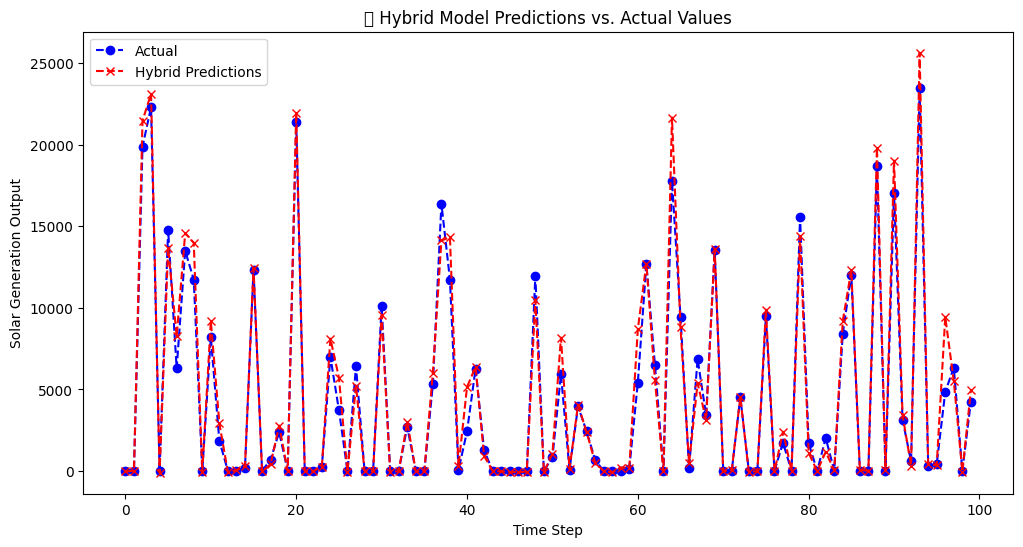

In [98]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot Actual vs Hybrid Predictions
plt.plot(y_test.values[:100], label="Actual", marker='o', linestyle='dashed', color='blue')
plt.plot(hybrid_preds[:100], label="Hybrid Predictions", marker='x', linestyle='dashed', color='red')

plt.title("🔍 Hybrid Model Predictions vs. Actual Values")
plt.xlabel("Time Step")
plt.ylabel("Solar Generation Output")
plt.legend()
plt.show()


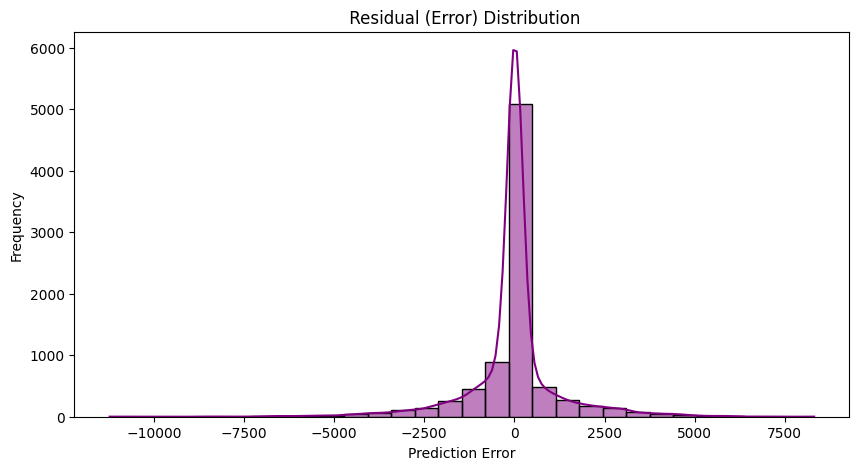

In [99]:
import seaborn as sns

residuals = y_test - hybrid_preds  # Difference between actual and predicted

plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, bins=30, color="purple")

plt.title(" Residual (Error) Distribution")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.show()


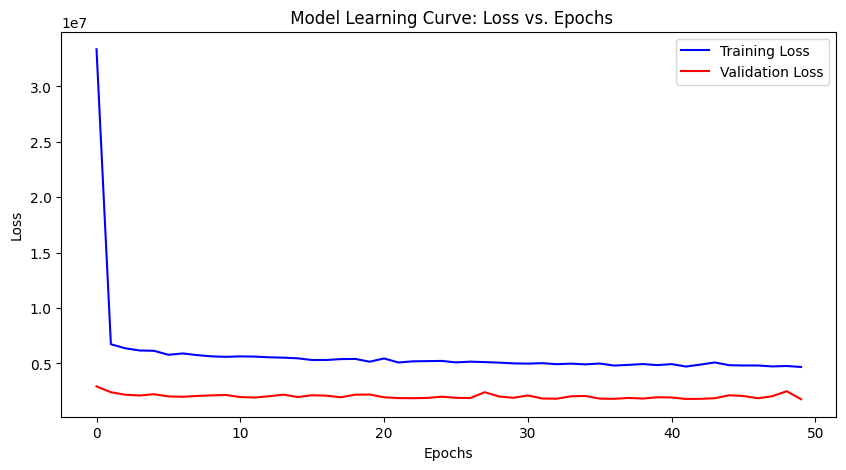

In [100]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label="Training Loss", color='blue')
plt.plot(history.history['val_loss'], label="Validation Loss", color='red')

plt.title(" Model Learning Curve: Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
